In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import shutil
import os

In [3]:
# Clear the current TensorFlow session
tf.keras.backend.clear_session()

In [4]:
train_path = './data/train'
test_path = './data/test'
valid_path = './data/val'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
#datadir = './data/'
working_dir=r'./'

In [5]:
dfs = {}
for d in [train_path, test_path, valid_path]:
    df_name = f"df_{d.split('/')[-1]}"
    dfs[df_name] = pd.DataFrame(columns=['filepaths', 'label'])
    filepath = []
    labels = []
    pd.DataFrame()
    classlist=os.listdir(d) 
    for c in classlist:
        label=list_of_classes[int(c)]
        classpath=os.path.join(d, c)
        flist = os.listdir(classpath)
        for f in flist:
            filepath.append(os.path.join(classpath,f))
            labels.append(label)
    filepaths=pd.Series(filepath, name='filepaths')
    labels=pd.Series(labels, name='labels')        
    dfs[df_name] = pd.concat([filepaths, labels], axis=1)

In [6]:
train_df = dfs['df_train']
valid_df = dfs['df_val']
test_df = dfs['df_test']

In [7]:
traind_lab_cnt = train_df.groupby('labels').count().reset_index().sort_values('filepaths', ascending=False)
traind_lab_cnt

,labels,filepaths
1,Healthy,2286
2,Minimal,1516
0,Doubtful,1047
3,Moderate,757
4,Severe,173


In [8]:
train_df['labels'].replace(['Healthy', 'Minimal', 'Doubtful'], 'Normal', inplace=True)
valid_df['labels'].replace(['Healthy', 'Minimal', 'Doubtful'], 'Normal', inplace=True)
test_df['labels'].replace(['Healthy', 'Minimal', 'Doubtful'], 'Normal', inplace=True)

In [9]:
traind_lab_cnt = train_df.groupby('labels').count().reset_index().sort_values('filepaths', ascending=False)
traind_lab_cnt

,labels,filepaths
1,Normal,4849
0,Moderate,757
2,Severe,173


In [10]:
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)        

In [11]:
# Create class directories within the augmented data directory
for label in train_df['labels'].unique():
    dir_path = os.path.join(aug_dir, label)
    os.mkdir(dir_path)

In [12]:
gen=ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)

In [13]:
epoch = 10
size = 150
rescale = 1./255.
#rescale = 1./127.5
#weight = 'imagenet'
weight = None
nb_img = 1000
batch_size = 16

In [14]:
total = 0
for v in traind_lab_cnt.values:
    print(v[0])
    print(v[1])
    if v[1] < nb_img:
        print(f'classe inf a {nb_img} : ', v[0], '=' , v[1])
        aug_img_count=0
        delta = nb_img - v[1]
        target_dir=os.path.join(aug_dir, v[0])
        aug_gen=gen.flow_from_dataframe( train_df.groupby('labels').get_group(v[0]),  x_col='filepaths', y_col=None, target_size=(size,size),
                                        class_mode=None, batch_size=1, shuffle=False, 
                                        save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                        save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images)
        total +=aug_img_count
        print('nbre images ajoutées:',aug_img_count)
    elif v[1] > nb_img:
        samples = train_df[train_df['labels'] == v[0]].sample(n=nb_img, random_state=42)
        train_df = train_df[train_df['labels'] != v[0]]
        train_df.reset_index(drop=True, inplace=True)
        train_df = train_df.append(samples, ignore_index=True)
        
print('Total Augmented images created= ', total)

Normal
4849


/tmp/ipykernel_4099/1741525926.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(samples, ignore_index=True)


Moderate
757
classe inf a 1000 :  Moderate = 757
Found 757 validated image filenames.
nbre images ajoutées: 243
Severe
173
classe inf a 1000 :  Severe = 173
Found 173 validated image filenames.
nbre images ajoutées: 827
Total Augmented images created=  1070


In [15]:
!pip install scipy

In [16]:
aug_fpaths=[]
aug_labels=[]
aug_class=os.listdir(aug_dir)
for c in aug_class:
    classpath=os.path.join(aug_dir, c)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(c)
Fseries=pd.Series(aug_fpaths, name='filepaths')
Lseries=pd.Series(aug_labels, name='labels')
aug_df=pd.concat([Fseries, Lseries], axis=1)         
train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
print('Length of augmented dataframe is now ', len(train_df))

Length of augmented dataframe is now  3000


In [17]:
train_df.groupby('labels').count()

,filepaths
labels,
Moderate,1000
Normal,1000
Severe,1000


In [18]:
train_igen=ImageDataGenerator(preprocessing_function=preprocess_input , horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,   #% shift
    height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    cval=125)
test_igen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen=train_igen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(size,size),
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)


valid_gen=test_igen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(size,size),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 3000 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.


In [19]:
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print(test_batch_size,',', test_steps)

72 , 23


In [20]:
test_gen=test_igen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(200,200),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 1656 validated image filenames belonging to 3 classes.


In [21]:
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

test batch size:  72   test steps:  23  number of classes :  3


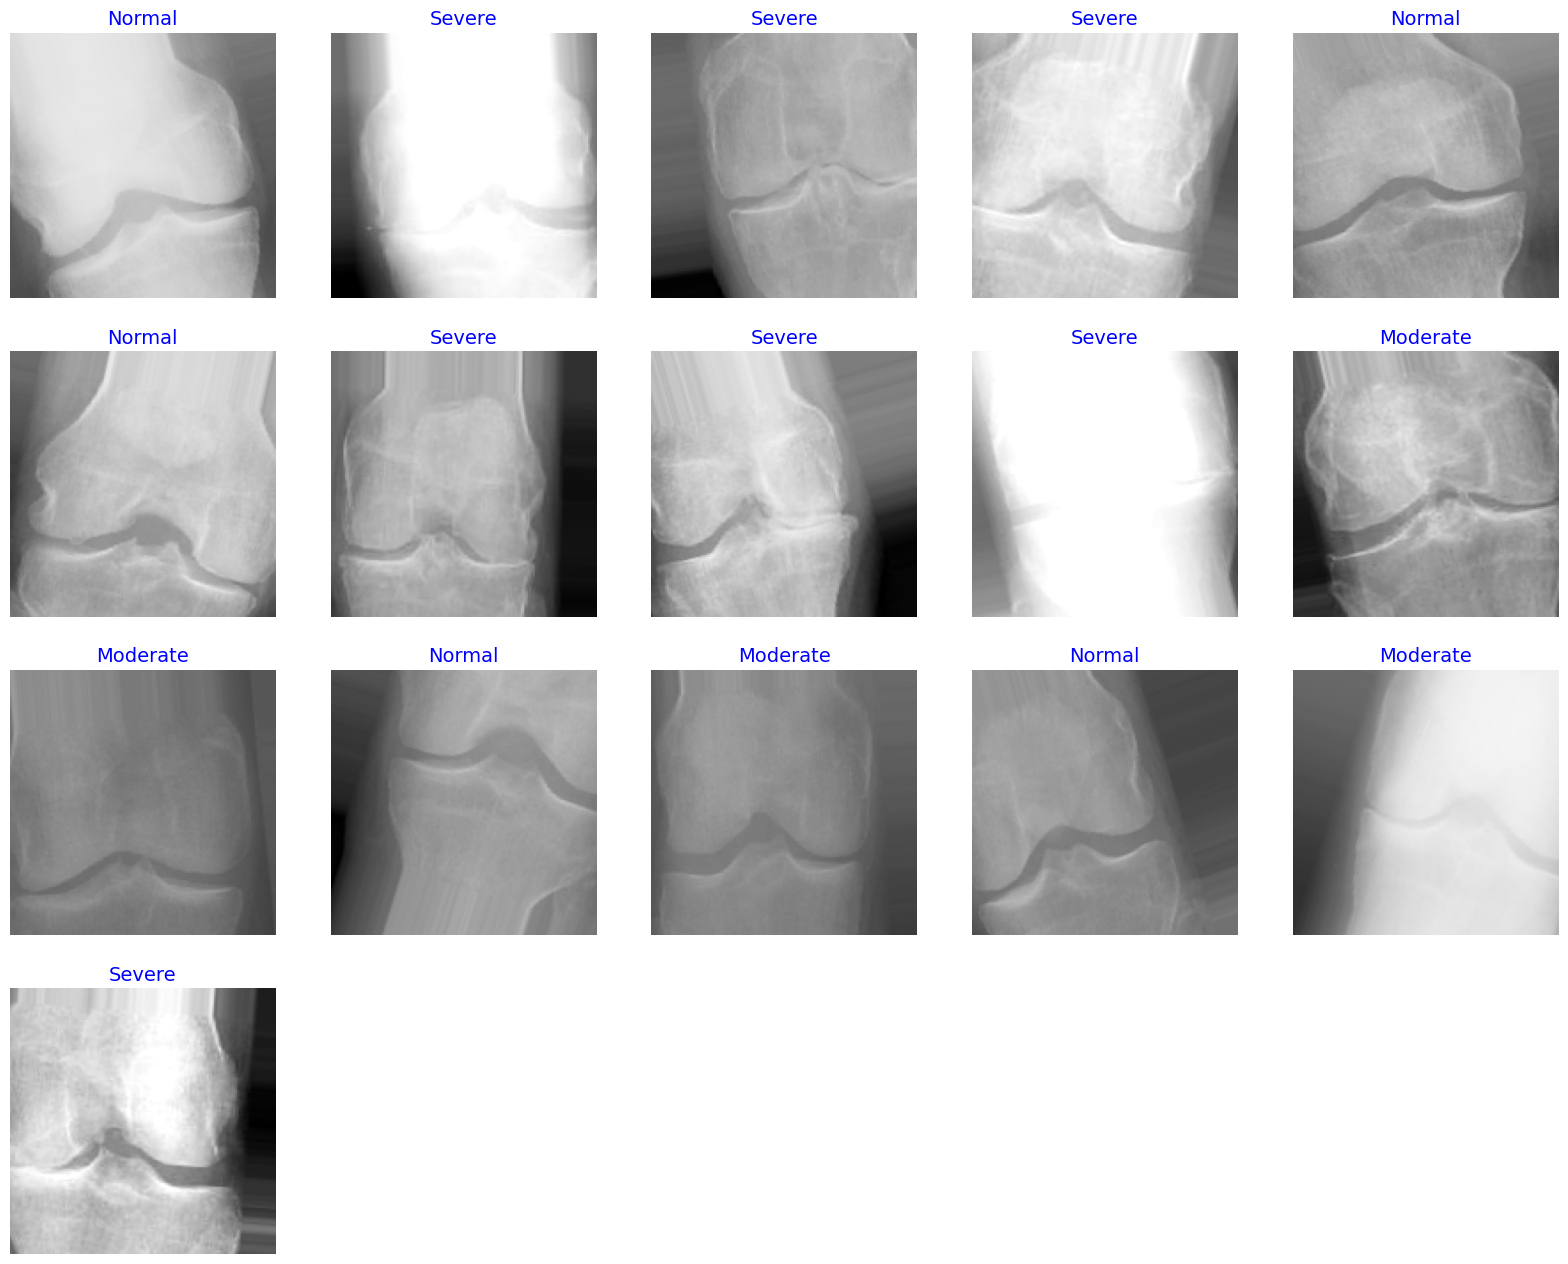

In [22]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i]  /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [ ]:
import keras_tuner
import keras
from keras.callbacks import ModelCheckpoint

def build_model(hp):
    base_model = keras.applications.In(weights='imagenet', include_top=False, input_shape=(size, size, 3))
    
    base_model.trainable = True

    flatten_layer = keras.layers.Flatten()(base_model.output)
    inner_layer = keras.layers.Dense(
        hp.Choice('units', [128, 512]), 
        activation='relu'
    )(flatten_layer)
    
    outputs = keras.layers.Dense(3, activation='softmax')(inner_layer)
    
    model = keras.Model(base_model.input, outputs)
    
    lr = hp.Choice('learning_rate', [0.001, 0.0001])
    optimizer = keras.optimizers.Adamax(learning_rate=lr)
    loss = keras.losses.CategoricalCrossentropy()
    batch_size = hp.Choice('batch_size', [16, 32])
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

#checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)
                   
tuner.search(train_gen, epochs=epoch, validation_data=valid_gen, batch_size=batch_size
             #, callbacks=[checkpoint_callback]
            )
best_model = tuner.get_best_models()[0]

In [22]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 3 summary
Hyperparameters:
units: 128
learning_rate: 0.0001
batch_size: 16
Score: 0.17901788651943207

Trial 4 summary
Hyperparameters:
units: 512
learning_rate: 0.0001
batch_size: 16
Score: 0.18371310830116272

Trial 0 summary
Hyperparameters:
units: 512
learning_rate: 0.001
batch_size: 32
Score: 0.21148790419101715

Trial 2 summary
Hyperparameters:
units: 512
learning_rate: 0.001
batch_size: 16
Score: 0.22560033202171326

Trial 1 summary
Hyperparameters:
units: 128
learning_rate: 0.001
batch_size: 32
Score: 0.23844090104103088


In [ ]:
#training best model

Epoch 1/50
188/188 [==============================] - 29s 128ms/step - loss: 0.2098 - accuracy: 0.9203 - val_loss: 0.2960 - val_accuracy: 0.8777
Epoch 2/50
188/188 [==============================] - 23s 124ms/step - loss: 0.2135 - accuracy: 0.9213 - val_loss: 0.2063 - val_accuracy: 0.9092
Epoch 3/50
188/188 [==============================] - 23s 123ms/step - loss: 0.1825 - accuracy: 0.9300 - val_loss: 0.1916 - val_accuracy: 0.9213
Epoch 4/50
188/188 [==============================] - 24s 125ms/step - loss: 0.1874 - accuracy: 0.9260 - val_loss: 0.2224 - val_accuracy: 0.9128
Epoch 5/50
188/188 [==============================] - 23s 124ms/step - loss: 0.1881 - accuracy: 0.9290 - val_loss: 0.1784 - val_accuracy: 0.9346
Epoch 6/50
188/188 [==============================] - 23s 122ms/step - loss: 0.1652 - accuracy: 0.9357 - val_loss: 0.1887 - val_accuracy: 0.9225
Epoch 7/50
188/188 [==============================] - 23s 123ms/step - loss: 0.1580 - accuracy: 0.9377 - val_loss: 0.1970 - val_ac

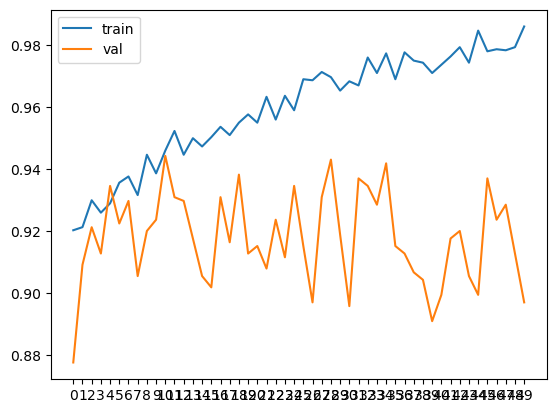

In [24]:
epoch = 50
#checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
history=best_model.fit(train_gen,  epochs=epoch, validation_data=valid_gen
                       #, callbacks=[checkpoint_callback]
                      )
best_model.save('resnet_model.h5')

#converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
#tflite_model = converter.convert()
#with open('xr_knee_mod.tflite', 'wb') as f:
#    f.write(tflite_model)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(epoch))
plt.legend()

52/52 [==============================] - 2s 31ms/step


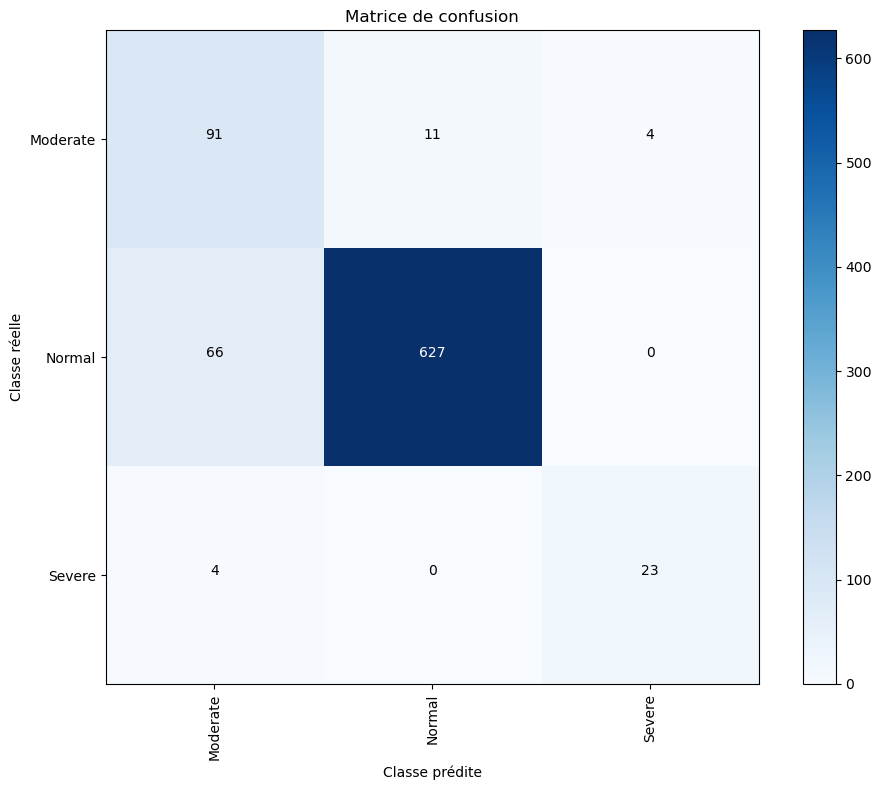

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred = history.model.predict(valid_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = valid_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.colorbar()

class_names = valid_gen.class_indices
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model_path = './resnet_model.h5'
loaded_model = load_model(model_path, compile = False)
tf.saved_model.save(loaded_model, 'my_model')

In [ ]:
# Model without using keras tuner

In [23]:
base_model_wt = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(size, size, 3))
base_model_wt.trainable = True

flatten_layer = keras.layers.Flatten()(base_model_wt.output)
inner_layer = keras.layers.Dense(512, 
    activation='relu'
)(flatten_layer)

outputs = keras.layers.Dense(3, activation='softmax')(inner_layer)

model_wt = keras.Model(base_model_wt.input, outputs)

lr = 0.0001
optimizer = keras.optimizers.Adamax(learning_rate=lr)
loss = keras.losses.CategoricalCrossentropy()

model_wt.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

2024-01-22 19:48:45.300266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-22 19:48:45.306053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-22 19:48:45.306634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-22 19:48:45.307563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10


2024-01-22 19:48:56.164663: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-01-22 19:48:56.823300: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-22 19:48:56.823938: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-22 19:48:56.823985: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-22 19:48:56.824448: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-22 19:48:56.824533: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


188/188 [==============================] - 35s 132ms/step - loss: 0.9814 - accuracy: 0.5797 - val_loss: 0.5683 - val_accuracy: 0.7651
Epoch 2/10
188/188 [==============================] - 22s 117ms/step - loss: 0.7312 - accuracy: 0.6780 - val_loss: 0.4825 - val_accuracy: 0.8414
Epoch 3/10
188/188 [==============================] - 22s 117ms/step - loss: 0.6579 - accuracy: 0.7003 - val_loss: 0.4309 - val_accuracy: 0.8305
Epoch 4/10
188/188 [==============================] - 22s 117ms/step - loss: 0.5830 - accuracy: 0.7390 - val_loss: 0.3452 - val_accuracy: 0.8668
Epoch 5/10
188/188 [==============================] - 22s 117ms/step - loss: 0.5307 - accuracy: 0.7723 - val_loss: 0.3337 - val_accuracy: 0.8644
Epoch 6/10
188/188 [==============================] - 22s 116ms/step - loss: 0.4836 - accuracy: 0.7973 - val_loss: 0.2908 - val_accuracy: 0.8789
Epoch 7/10
188/188 [==============================] - 22s 117ms/step - loss: 0.4348 - accuracy: 0.8150 - val_loss: 0.2726 - val_accuracy: 0.8

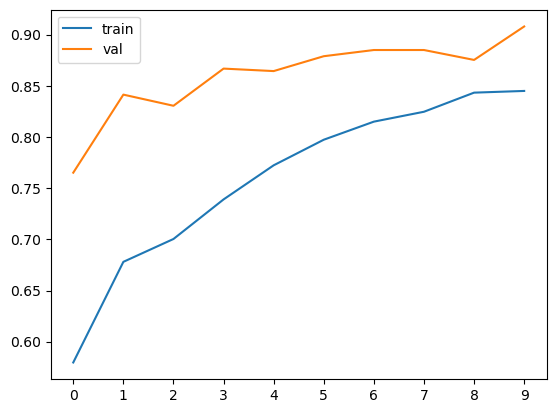

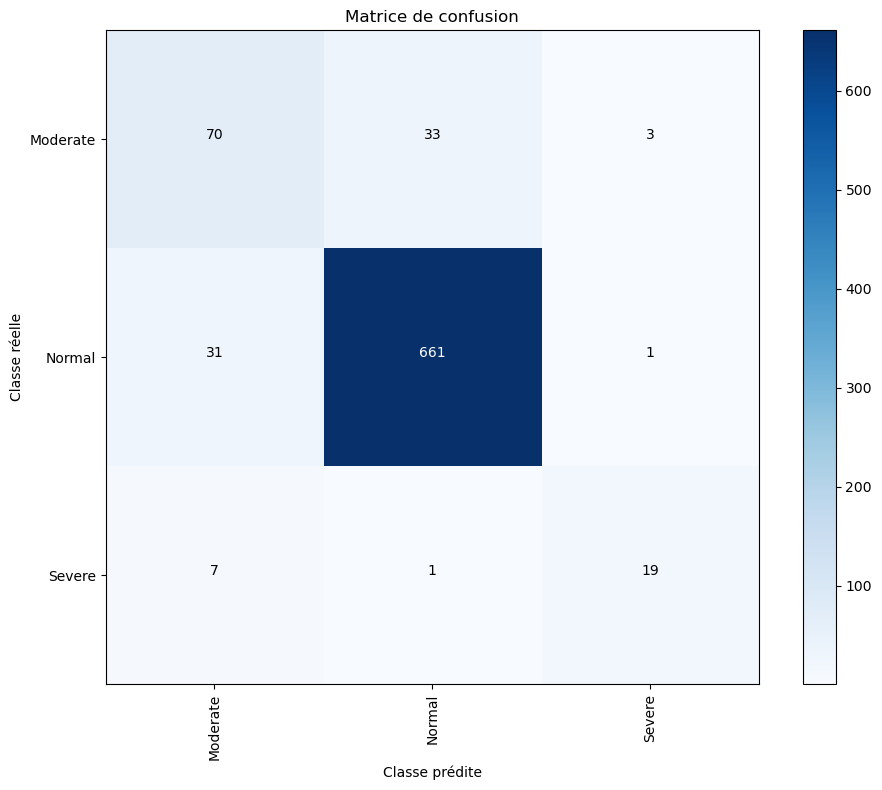

In [24]:
history_wt=model_wt.fit(train_gen,  epochs=10, validation_data=valid_gen, batch_size=16)
plt.plot(history_wt.history['accuracy'], label='train')
plt.plot(history_wt.history['val_accuracy'], label='val')
plt.xticks(np.arange(epoch))
plt.legend()

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
                   
y_pred = history_wt.model.predict(valid_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = valid_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.colorbar()

class_names = valid_gen.class_indices
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
                          

In [25]:
model_wt.save_weights('weights.h5')

In [26]:
model_wt.save_spec('specs.h5')

([TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_1')], {})

In [27]:
model_wt.save('model.h5')

In [28]:
import tensorflow as tf
from tensorflow.keras.models import load_model
modell = load_model('model.h5', compile = False)

In [29]:
tf.saved_model.save(modell, 'my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model_wt.save('inceptionv3.h5')

model_path = './inceptionv3.h5'
loaded_model = load_model(model_path, compile = False)
tf.saved_model.save(loaded_model, 'my_model')